In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

## 1. Realizar un análisis exploratorio de los datos para identificar relaciones entre variables, valores atípicos, tendencias, etc. 🔍

In [97]:
#importo el dataset
dataset = pd.read_csv("Mall_Customers.csv")
dataset.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [99]:
#Descripción
dataset.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Text(0.5, 1.0, 'Identificación de Datos Faltantes y Atípicos')

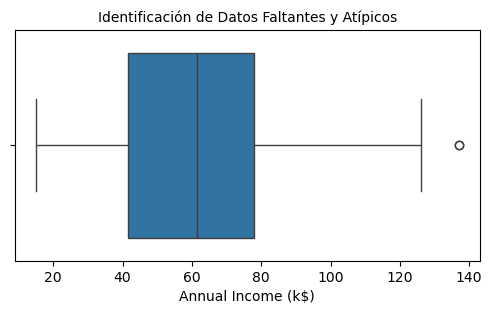

In [101]:
#identifico datos faltantes 

plt.figure(figsize=(6, 3))
sns.boxplot(x=dataset['Annual Income (k$)'])
plt.title('Identificación de Datos Faltantes y Atípicos', fontsize=10 )

## 2. Preprocesar los datos limpiándolos, tratando valores faltantes y transformándolos según sea necesario. ⚙️

In [103]:
# reviso datos faltantes
print("Cantidad de Registros con cero en Edad: ",dataset['Age'].isin([0]).sum())
print("Cantidad de Registros con cero en Ingresos Anuales: ",dataset['Annual Income (k$)'].isin([0]).sum())
print("Cantidad de Registros con cero en Puntuación de gastos: ",dataset['Spending Score (1-100)'].isin([0]).sum())

Cantidad de Registros con cero en Edad:  0
Cantidad de Registros con cero en Ingresos Anuales:  0
Cantidad de Registros con cero en Puntuación de gastos:  0


In [105]:
# Reemplazar todos los ceros con el valor medio
count_zeros = (dataset['Annual Income (k$)'] == 0).sum()

# Reemplazar los valores de 0 por la media
dataset['Annual Income (k$)']= dataset['Annual Income (k$)'].replace(0,dataset['Annual Income (k$)'].mean())

# Imprimir el número de valores modificados
print(f"Se cambiaron {count_zeros} valores.")

Se cambiaron 0 valores.


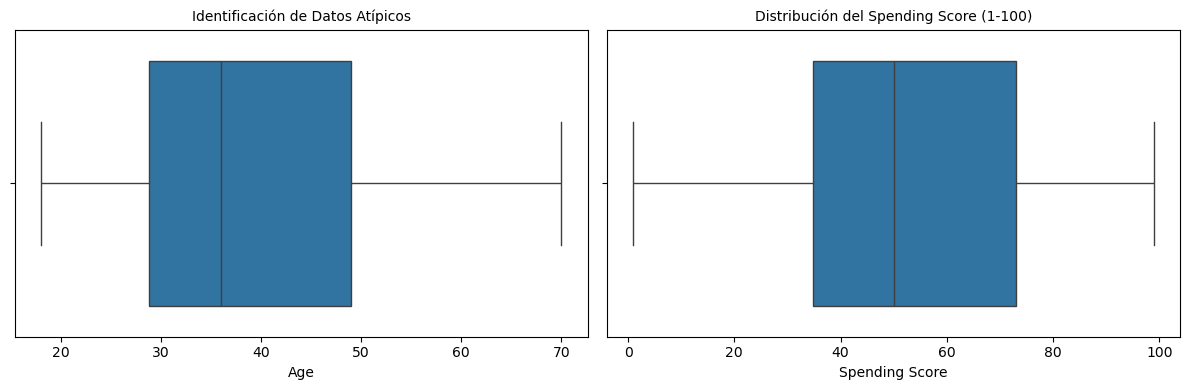

In [107]:
#Identifico los datos Atípicos Age

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  


sns.boxplot(x=dataset['Age'], ax=axes[0])
axes[0].set_title('Identificación de Datos Atípicos', fontsize=10)
axes[0].set_xlabel('Age')


sns.boxplot(x=dataset['Spending Score (1-100)'], ax=axes[1])
axes[1].set_title('Distribución del Spending Score (1-100)', fontsize=10)
axes[1].set_xlabel('Spending Score')


plt.tight_layout()
plt.show()



In [109]:
#Conteo de Datos Atípicos 

#Age
nivel_minimo=18
nivel_maximo=70
Total_Atipicos=((dataset['Age']<nivel_minimo)|
                (dataset['Age']>nivel_maximo)).sum()
print("El total de datos atípicos es {}".format(Total_Atipicos))

# Spending Score
nivel_minimo = 0
nivel_maximo = 100
Total_Atipicos_Spending = ((dataset['Spending Score (1-100)'] < nivel_minimo) | 
                           (dataset['Spending Score (1-100)'] > nivel_maximo)).sum()

print("El total de datos atípicos en Spending Score es {}".format(Total_Atipicos_Spending))


El total de datos atípicos es 0
El total de datos atípicos en Spending Score es 0


In [62]:
# reiviso los datos
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


## 3. Seleccionar las características más relevantes para entrenar el modelo utilizando selección de características. 📤📥

Características de interes para el agrupamiento:
- Age
- Annual Income (k$)	
- Spending Score (1-100)

In [113]:
# Filtro columnas del modelo 

print("Total de filas en el dataset:", dataset.shape[0])
dataset = dataset[["Age", "Annual Income (k$)","Spending Score (1-100)"]]
dataset.head(10)

Total de filas en el dataset: 200


,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
5,22,17,76
6,35,18,6
7,23,18,94
8,64,19,3
9,30,19,72


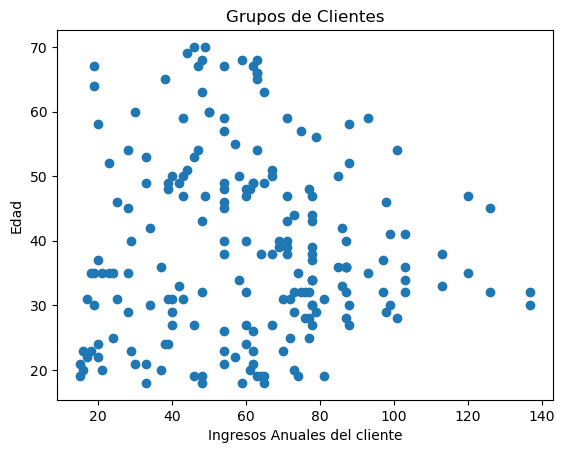

In [117]:
# Grafica antes del agrupamiento

plt.scatter(dataset['Annual Income (k$)'], dataset['Age'])
plt.xlabel('Ingresos Anuales del cliente')
plt.ylabel('Edad')
plt.title('Grupos de Clientes')
plt.show()

## 4. Entrenar el modelo configurando los diferentes hiperparámetros. 🪖

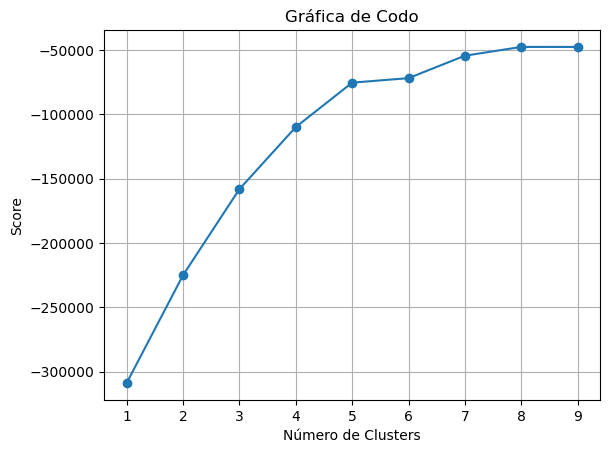

In [130]:
# gráfica de Codo de Jambú

Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(dataset).score(dataset) for i in range(len(kmeans))]

plt.plot(Nc, score, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')
plt.title('Gráfica de Codo')
plt.grid(True)
plt.show()

In [134]:
# Generación del modelo de Agrupamiento

Modelo = KMeans(n_clusters=5, random_state=0)
Modelo.fit(dataset)

KMeans(n_clusters=5, random_state=0)

In [140]:
#Se agrega la columna Grupo a la BD para identificar el numero de grupo del agrupamiento

Modelo.labels_
dataset["Grupo"] = Modelo.labels_ 
print (dataset)

     Age  Annual Income (k$)  Spending Score (1-100)  Grupo
0     19                  15                      39      2
1     21                  15                      81      2
2     20                  16                       6      0
3     23                  16                      77      2
4     31                  17                      40      0
..   ...                 ...                     ...    ...
195   35                 120                      79      1
196   45                 126                      28      3
197   32                 126                      74      1
198   32                 137                      18      3
199   30                 137                      83      1

[200 rows x 4 columns]


## 5. Evaluar el desempeño del modelo con métricas como Coeficiente de Silhouette, Índice de Calinski-Harabasz, etc 📈

In [150]:
# Desempeño del modelo

# Preparación de la metrica de la columna Grupo
Observaciones = len(dataset)
X = dataset.drop('Grupo', axis=1)
clusters = dataset['Grupo']

# Se calculan las métricas
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Se crea una tabla para mostrar los valores de las métricas
table_data = [
    ["Numero de Observaciones", Observaciones],
    ["Coeficiente Silhouette", sil_score],
    ["Indice Calinski Harabasz", calinski_score],
    ["Indice Davies Bouldin", davies_score]
]

# Imprime la tabla
from tabulate import tabulate
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+--------------------------+--------------------+
|          Metric          |       Value        |
+--------------------------+--------------------+
| Numero de Observaciones  |        200         |
|  Coeficiente Silhouette  | 0.3771108731967625 |
| Indice Calinski Harabasz | 133.49030043802063 |
|  Indice Davies Bouldin   | 0.9845471043038023 |
+--------------------------+--------------------+


## 6. Realizar las diferentes gráficas que permitan visualizar los resultados del modelo 🖌️

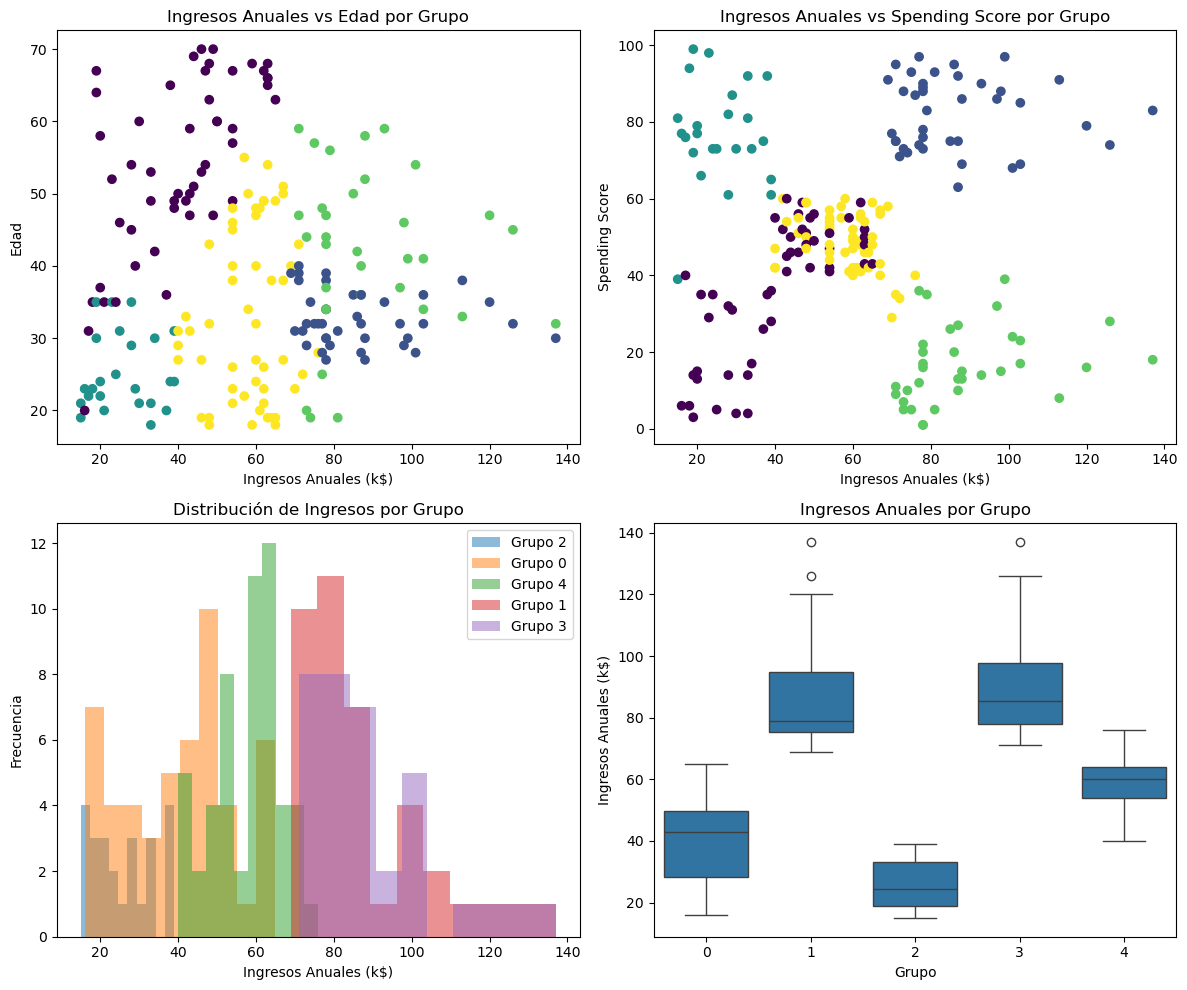

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].scatter(dataset['Annual Income (k$)'], dataset['Age'], c=dataset['Grupo'], cmap='viridis')
axes[0, 0].set_title('Ingresos Anuales vs Edad por Grupo')
axes[0, 0].set_xlabel('Ingresos Anuales (k$)')
axes[0, 0].set_ylabel('Edad')

axes[0, 1].scatter(dataset['Annual Income (k$)'], dataset['Spending Score (1-100)'], c=dataset['Grupo'], cmap='viridis')
axes[0, 1].set_title('Ingresos Anuales vs Spending Score por Grupo')
axes[0, 1].set_xlabel('Ingresos Anuales (k$)')
axes[0, 1].set_ylabel('Spending Score')

for grupo in dataset['Grupo'].unique():
    subset = dataset[dataset['Grupo'] == grupo]
    axes[1, 0].hist(subset['Annual Income (k$)'], bins=10, alpha=0.5, label=f'Grupo {grupo}')
axes[1, 0].set_title('Distribución de Ingresos por Grupo')
axes[1, 0].set_xlabel('Ingresos Anuales (k$)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].legend()

sns.boxplot(x='Grupo', y='Annual Income (k$)', data=dataset, ax=axes[1, 1])
axes[1, 1].set_title('Ingresos Anuales por Grupo')
axes[1, 1].set_xlabel('Grupo')
axes[1, 1].set_ylabel('Ingresos Anuales (k$)')

plt.tight_layout()
plt.show()


## 7. Interpretar, analizar y documentar los resultados obtenidos.

Coeficiente de Silhouette: La puntuación de Silhouette obtenida es de aproximadamente 0.3771, lo que sugiere una separación moderada entre los grupos. Aunque no se acerca al valor ideal de 1, que indicaría una clara separación, este valor indica que los grupos están razonablemente diferenciados. En general, una puntuación más alta sería más deseable, pero este valor nos señala que el modelo ha logrado segmentar los datos de manera aceptable. Sin embargo, una mayor separación podría ser alcanzada al ajustar parámetros como el número de clusters.

Índice de Calinski-Harabasz: La puntuación de 133.49 en el índice de Calinski-Harabasz es un buen indicativo de que los clústeres están relativamente bien definidos. Este índice mide la dispersión entre los grupos en relación con la dispersión dentro de cada grupo, por lo que una puntuación más alta refleja una mayor separación entre los clústeres. Aunque sería ideal obtener un valor aún mayor, la puntuación actual indica que los grupos tienen una estructura coherente y bien diferenciada, lo que sugiere que el modelo ha logrado una segmentación efectiva.

Índice Davies-Bouldin: La puntuación obtenida en el índice de Davies-Bouldin es 0.9845, lo que refleja un nivel moderado de separación entre los grupos. Este índice mide la distancia entre los centros de los grupos en comparación con la dispersión dentro de cada grupo, donde una puntuación baja indica una mejor separación. Con un valor cercano a 1, se puede inferir que la separación entre los grupos es decente, aunque aún existen algunas áreas de superposición. Una puntuación más baja sería ideal, por lo que se podrían realizar ajustes adicionales en el modelo para mejorar la segmentación y reducir la similitud entre los grupos.